<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-2b:-Bayesian-inference-(R)" data-toc-modified-id="Chapter-2b:-Bayesian-inference-(R)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chapter 2b: Bayesian inference (R)</a></span><ul class="toc-item"><li><span><a href="#1.-Seismicity-statistics" data-toc-modified-id="1.-Seismicity-statistics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>1. Seismicity statistics</a></span><ul class="toc-item"><li><span><a href="#1.1.-Seismicity-data" data-toc-modified-id="1.1.-Seismicity-data-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>1.1. Seismicity data</a></span></li><li><span><a href="#1.2.-Understanding-completeness-magnitude-$m_c$" data-toc-modified-id="1.2.-Understanding-completeness-magnitude-$m_c$-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>1.2. Understanding completeness magnitude $m_c$</a></span></li></ul></li><li><span><a href="#2.-Bayesian-Magnitude-of-Completeness-(BMC)" data-toc-modified-id="2.-Bayesian-Magnitude-of-Completeness-(BMC)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>2. Bayesian Magnitude of Completeness (BMC)</a></span><ul class="toc-item"><li><span><a href="#2.1.-Likelihood-distribution" data-toc-modified-id="2.1.-Likelihood-distribution-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>2.1. Likelihood distribution</a></span></li><li><span><a href="#2.2.-Prior-distribution" data-toc-modified-id="2.2.-Prior-distribution-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>2.2. Prior distribution</a></span></li><li><span><a href="#2.3.-Posterior-distribution" data-toc-modified-id="2.3.-Posterior-distribution-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>2.3. Posterior distribution</a></span></li></ul></li><li><span><a href="#3.-References" data-toc-modified-id="3.-References-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>3. References</a></span></li></ul></li></ul></div>

# Chapter 2b: Bayesian inference (R)

In this notebook, we will do our second Bayesian inference model consisting in infering the completeness magnitude $m_c$ of an earthquake catalogue based on a prior model relating $m_c$ to the spatial density of seismic stations. The method is called 'Bayesian Magnitude of Completeness' (BMC) and was proposed by Mignan et al. (2011).

In contrast with the previous notebook '_Chapter 2a: Bayesian inference (Python)_', we will here use R as programming language. It is important for Machine Learning practitioners to be confortable with multiple languages. R and Python are the 2 most common languages used in data science and machine learning.

The two examples of Chapter 2b are based on the same Bayesian inference method. Only the data and the types of probability distributions differ:
* Beta distribution & Binomial distribution: the previous notebook
* **Gaussian distribution**: the present notebook

First, let us define a few functions in R:

In [5]:
floor(3.5) #Return the integer no larger than x

[1] 3

In [6]:
ceiling(3.5) #Return the integer no smaller than x

[1] 4

In [16]:
seq(floor(0),ceiling(121),20) # np.arange

[1]   0  20  40  60  80 100 120

In [20]:
seq1 = c(10,20:30)
seq1  #c() combine

[1] 10 20 21 22 23 24 25 26 27 28 29 30

In [26]:
mean(seq1[1:10]) # min, max, sum, mean, varb

[1] 22.6

In [55]:
seq2 = c(-1,rep(0,20),1)
dens = density(seq2,from=-1, to=1)
dens


Call:
	density.default(x = seq2, from = -1, to = 1)

Data: seq2 (22 obs.);	Bandwidth 'bw' = 0.1497

       x              y           
 Min.   :-1.0   Min.   :0.003714  
 1st Qu.:-0.5   1st Qu.:0.020221  
 Median : 0.0   Median :0.090010  
 Mean   : 0.0   Mean   :0.477043  
 3rd Qu.: 0.5   3rd Qu.:0.592881  
 Max.   : 1.0   Max.   :2.421947  

In [52]:
seq2[which(seq2 > -1)]

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1

In [97]:
which(seq2 > -1) #which() returns the index

[1]  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22

In [2]:
# Frequency-magnitude distribution
fmd <- function(m, mbin = 0.1) {
  mmin <- min(m, na.rm = T) # Remove na
  mmax <- max(m, na.rm = T)
  mi <- seq(floor(mmin / mbin) * mbin, ceiling(mmax / mbin) * mbin, mbin)
  ni <- hist(m, breaks = c(mi, mmax + mbin) - mbin / 2, plot = F)$counts #hist(data, breaks=#xticks#,plot=F(frequency)/P(probability))
  Ni <- sapply(1:length(ni), function(i) sum(ni[i:length(ni)])) #Index starts from 1
  return(data.frame(mi = mi, ni = ni, Ni = Ni)) #mi:magnitude seq. ni:histogram eq. counts at mi Ni: cumulative eq. counts
}
      
# Completeness magnitude as mode of magnitude distribution
mc_mode <- function(m, mbin = 0.1) {
    dens <- density(m, from = min(m) - 1, to = max(m) + 1)
    return(round(dens$x[which(dens$y == max(dens$y))], digits = log10(1 / mbin))[1]) # which():where(arg*)
} #digits -> This value represents the number of decimal points that you wish to have for the number

# distance in km between some geographical points and a reference point
d_geo2km <- function(pt.ref, pt.list) {
    rad_earth <- 6378.1   #km
    lat_km <- rad_earth*pi/180 #from degree to rad
    lon_km <- rad_earth*cos(pt.ref$lat*pi/180)*pi/180
    d <- sqrt(((pt.ref$lon - pt.list$lon) * lon_km) ^ 2 + ((pt.ref$lat - pt.list$lat) * lat_km) ^ 2)
}

## 1. Seismicity statistics

### 1.1. Seismicity data

To understand the concept of completeness magnitude, an important metric of seismicity, let us first load an earthquake catalogue; we will use the Taiwan catalogue from 1991 to 2005 (Wu et al., 2008):

Download the electronic supplement of Wu et al. (2008): [catalogs_1991-2005.zip](https://www.seismosoc.org/Publications/BSSA_html/bssa_98-3/2007166-esupp/) and unzip in a `data` folder created in the current working directory. Change the name to `Taiwan_catalog19912005`. Add also the file `Taiwan_stations.dat` provided as course material.  

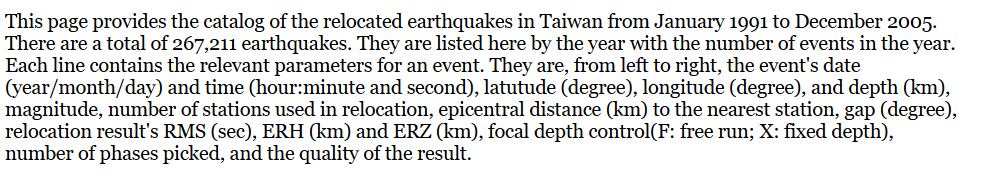

In [18]:
lon <- c(); lat <- c(); m <- c(); z <- c()
for(i in 1:15) {
    cat <- scan(file = paste0("data/Taiwan_catalog19912005/", 1990+i,".txt"), what="character", sep="\n")
    lon_tmp <- as.numeric(substr(cat, start=33, stop=40)) 
    lat_tmp <- as.numeric(substr(cat, start=25, stop=31))
    z_tmp <- as.numeric(substr(cat, start=42, stop=47))
    m_tmp <- as.numeric(substr(cat, start=49, stop=52))

    lon <- c(lon, lon_tmp)
    lat <- c(lat, lat_tmp)
    z <- c(z, z_tmp)
    m <- c(m, m_tmp)
}

seism <- data.frame(lat = lat, lon = lon, z = z, m = m)

# Station coordinates
stations <- read.table(paste0("data/Taiwan_stations.dat"), header = T)

In [72]:
head(seism)

lat,lon,z,m
23.8370,122.0325,16.53,3.31
23.7118,121.1982,13.66,2.84
23.7822,121.4363,1.82,3.64
24.6162,121.8715,68.42,2.52
23.8167,121.4380,2.10,3.28
23.8635,121.3267,3.59,3.47


### 1.2. Understanding completeness magnitude $m_c$

We use below the mode of the magnitude distribution to define the completeness magnitude $m_c$. This parameter gives the minimum magnitude bin above which the data can be considered complete and to follow the Gutenberg-Richter law (see `chap2a.ipynb` for the distribution). The mode is a reasonable approximation in small regions where $m_c$ can be assumed constant. In a large region of the size of Taiwan, $m_c$ varies in space (as we will see later) and therefore the mode slightly underestimes the completeness level.

Other methods could be used, but this is not needed to illustrate the upcoming Bayesian inference illustration. To clearly illustrate the importance of a correct estimate of $m_c$, the following animation (made with R!) shows the computed Gutenberg-Richter law as a function of minimum magnitude cut-off (recall that the $b-$value is the slope of the Gutenberg-Richter law from which probabilities of higher magnitudes can be extrapolated):

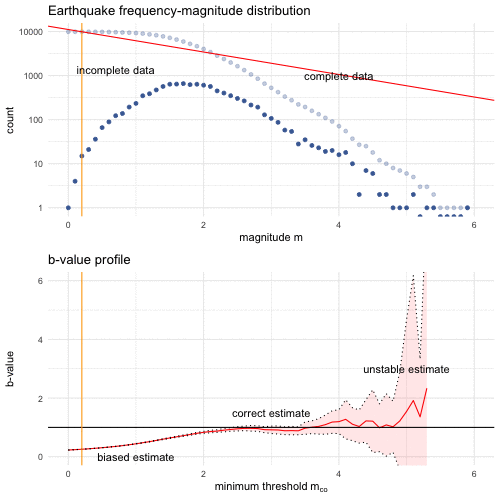

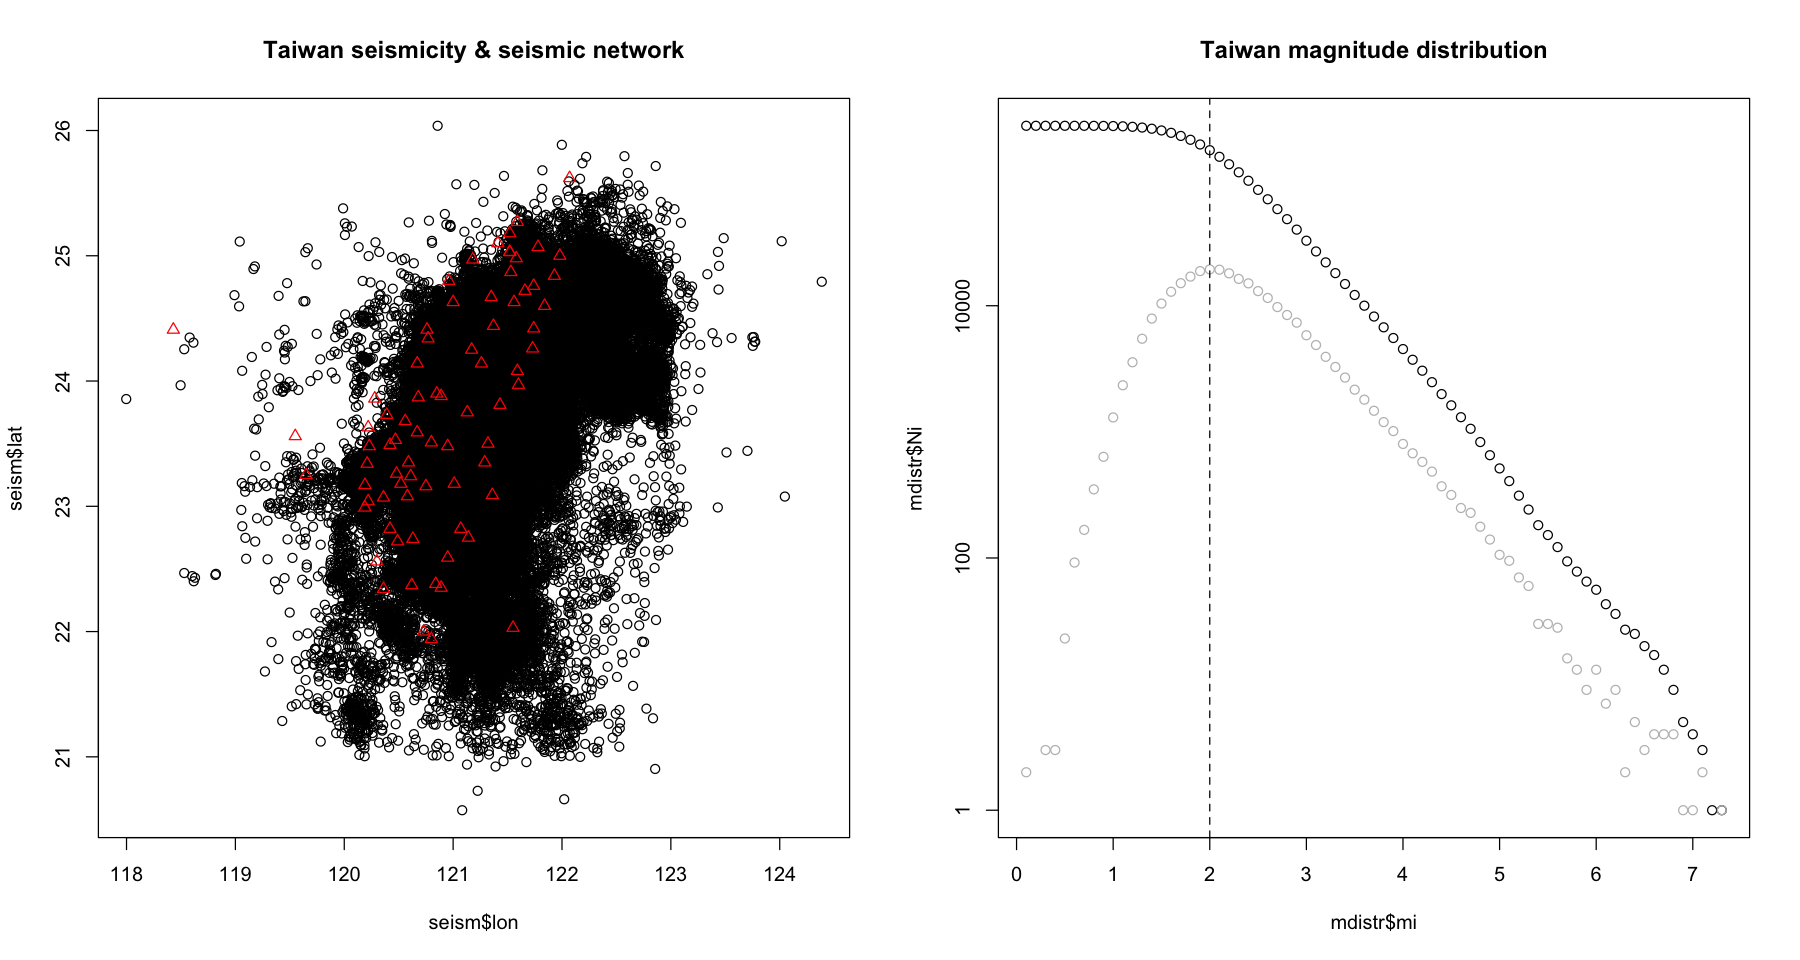

In [3]:
# plotting earthquake map with seismic stations and the earthquake magnitude distribution
mdistr <- fmd(seism$m)
mc_Taiwan <- mc_mode(seism$m)
options(repr.plot.width = 15, repr.plot.height = 8)
par(mfrow = c(1, 2))
plot(seism$lon, seism$lat, main = 'Taiwan seismicity & seismic network')
points(stations$lon, stations$lat, col = 'red', pch = 2)

plot(mdistr$mi, mdistr$Ni, log = 'y', main = 'Taiwan magnitude distribution') #CDF
points(mdistr$mi, mdistr$ni, , col = 'grey') #Density dis.
abline(v = mc_Taiwan, lty = 'dashed')

## 2. Bayesian Magnitude of Completeness (BMC)

### 2.1. Likelihood distribution

We will now map $m_c(lon,lat)$ in 0.5$^\circ$ bins. Those estimates correspond to our evidence (data) for Bayesian inference. We assume that the likelihood distribution is Gaussian with the $m_{c,obs}$ distribution per spatial cell estimated by bootstrapping (i.e. random sampling with replacement) (Efron, 1979).

In [58]:
dbin <- .2   #degrees
box <- c(floor(min(seism$lon)), ceiling(max(seism$lon)), floor(min(seism$lat)), ceiling(max(seism$lat)))
grid <- expand.grid(lon = seq(box[1], box[2], dbin), lat = seq(box[3], box[4], dbin)) #meshgrid
grid.n <- nrow(grid)
#index of cells containing seism data
ind.cell <- sapply(1:grid.n, function(i) which(seism$lon >= grid$lon[i] - dbin / 2 &   #Resample the seism
                                                   seism$lon < grid$lon[i] + dbin / 2 & #which() returns the index
                                                   seism$lat >= grid$lat[i] - dbin / 2 &
                                                   seism$lat < grid$lat[i] + dbin / 2))
            # sapply is an efficient alternative to for loops in R

# estimate mc distribution per spatial cell via bootstrapping
n_bootstrap <- 100
nmin <- 4    # get mc from mode if at least 4 earthquakes present, otherwise Not Available (NA)
mc_samples <- sapply(1:grid.n, function(i)
    if(length(unlist(ind.cell[i])) >= nmin) {  # random get samples                  repeat sample (put back)=True
      sapply(1:n_bootstrap, function(j) mc_mode(sample(seism$m[unlist(ind.cell[i])], replace = T))) 
    } else {NA})

# get the mean and standard deviation from the mc samples per spatial cell
mc_obs <- sapply(1:grid.n, function(i) mean(mc_samples[[i]], na.rm = T))
sigma_obs <- sapply(1:grid.n, function(i) sd(mc_samples[[i]], na.rm = T))

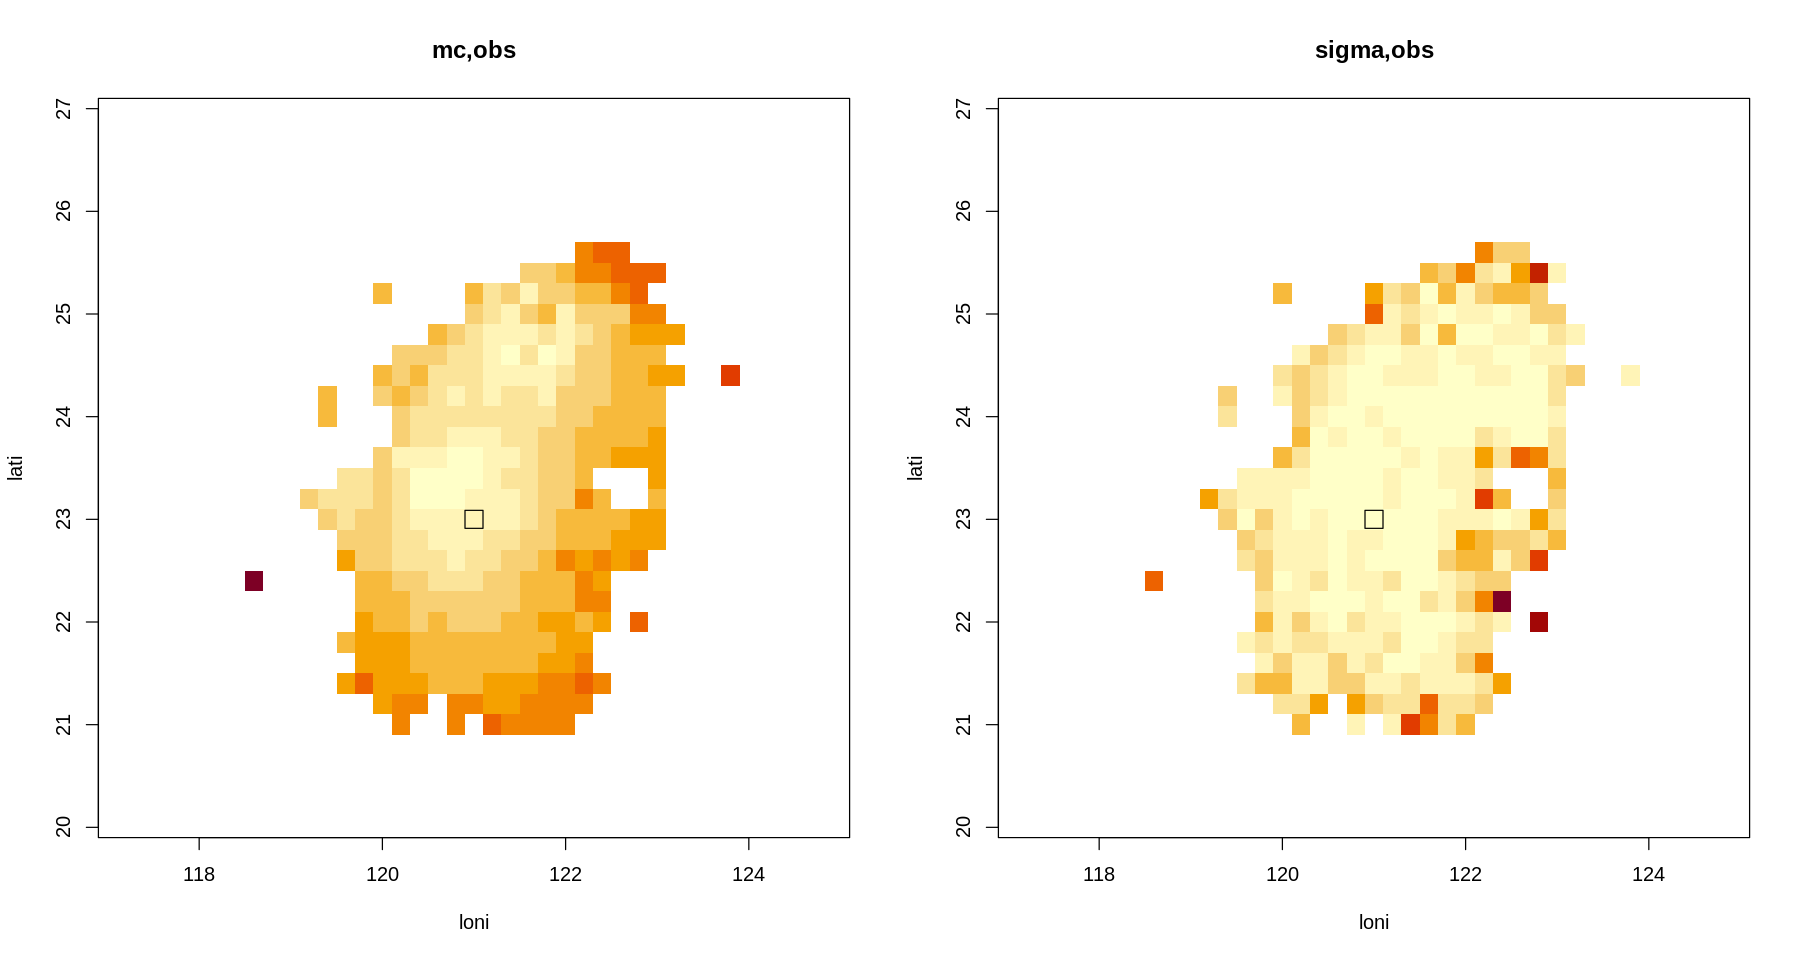

In [254]:
# map mc_obs & sigma_obs
loni <- unique(grid$lon)
lati <- unique(grid$lat)
indloc <- which(grid$lon >= 121 & grid$lat >= 23)[1]     # central area, low uncertainty on observation
#indloc <- which(grid$lon >= 121.5 & grid$lat >= 21)[1]   # outer regaion, higher uncertainty on observation
check_loc <- grid[indloc, ]

par(mfrow = c(1, 2))
image(loni, lati, matrix(mc_obs, nrow = length(loni), ncol = length(lati)), main = 'mc,obs')
points(check_loc$lon, check_loc$lat, pch = 0, cex = 10*dbin)
image(loni, lati, matrix(sigma_obs, nrow = length(loni), ncol = length(lati)), main = 'sigma,obs')
points(check_loc$lon, check_loc$lat, pch = 0, cex = 10*dbin)

Let us check the $m_{c,obs}$ distribution in the cell highlighted above.

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“1 y value <= 0 omitted from logarithmic plot”

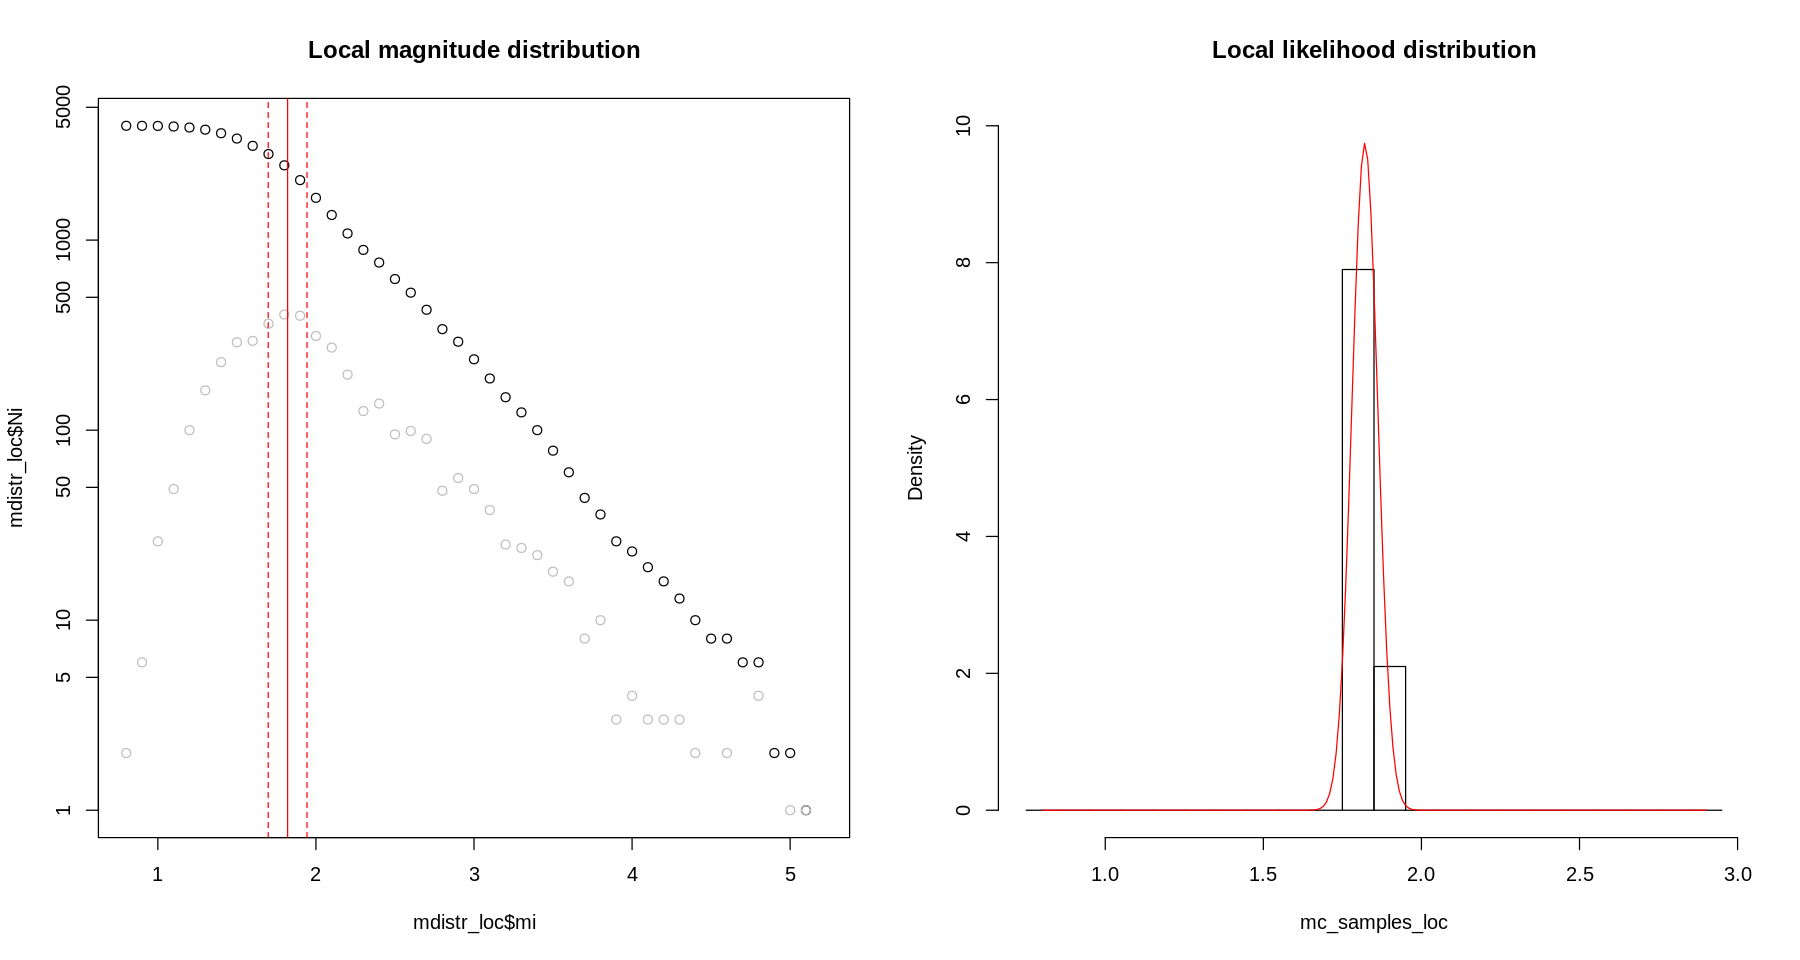

In [297]:
m_loc <- seism$m[unlist(ind.cell[indloc])]
mc_samples_loc <- mc_samples[[indloc]]
mc_obs_loc <- mc_obs[indloc]
sigma_obs_loc <- sigma_obs[indloc]

mdistr_loc <- fmd(m_loc)
par(mfrow = c(1, 2))
plot(mdistr_loc$mi, mdistr_loc$Ni, log = "y", main = "Local magnitude distribution")
points(mdistr_loc$mi, mdistr_loc$ni, , col = "grey")
abline(v = c(mc_obs_loc - 3*sigma_obs_loc, mc_obs_loc, mc_obs_loc + 3*sigma_obs_loc),
      lty = c('dashed', 'solid', 'dashed'), col = 'red')

breaks <- seq(min(mc_samples_loc, na.rm=T)-1.05, max(mc_samples_loc, na.rm=T)+1.05, .1)
hist(mc_samples_loc, breaks = breaks, freq = F, ylim = c(0, 10), main = 'Local likelihood distribution')
mci <- seq(min(mc_samples_loc, na.rm=T)-1, max(mc_samples_loc, na.rm=T)+1, .01)
lines(mci, dnorm(mci, mean = mc_obs_loc, sd = sigma_obs_loc), col = 'red')

### 2.2. Prior distribution

Our _a priori_ knowledge is a model relating $m_c$ to the spatial density of seismic stations, approximated by the distance to the nearest $k^{th}$ station. It is defined as $m_{c,pred} = c_1 d_k^{c_2}+c_3 \pm \sigma_{pred}$. As the distance $d_k$ increases, so does $m_c$. We here also describe the model with a Gaussian distribution with mean $m_{c,pred}$ and standard deviaon $\sigma_{pred}$.

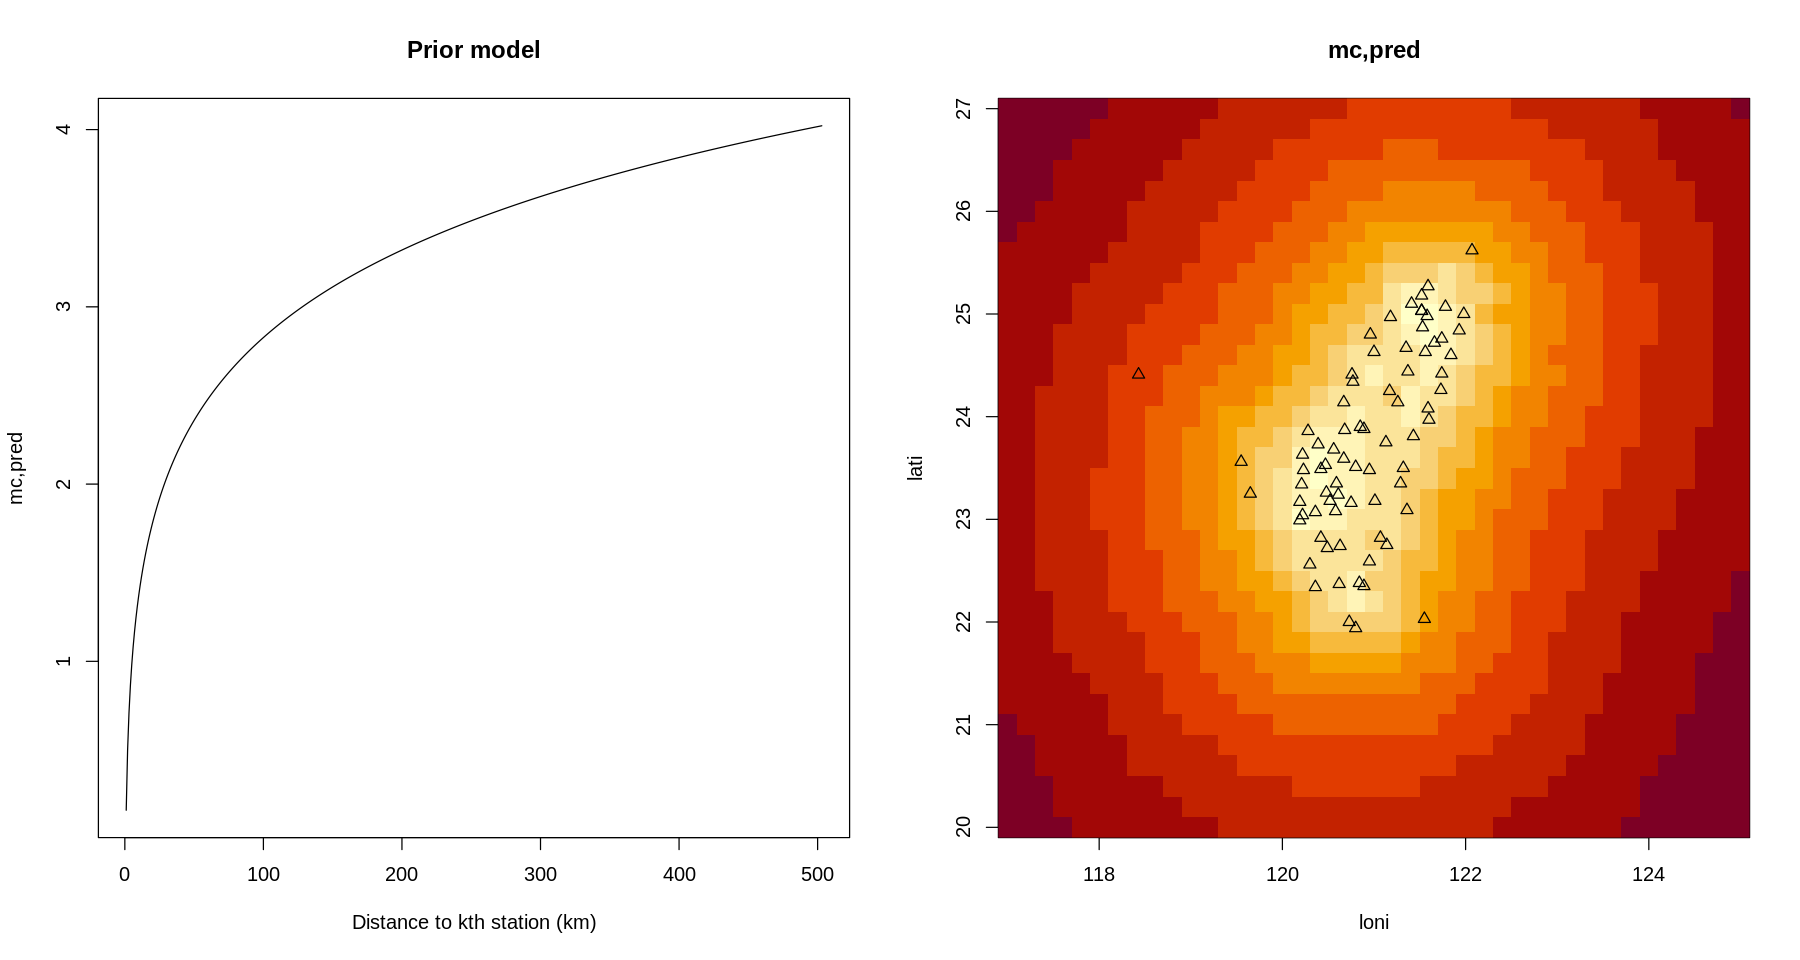

In [257]:
par_prior <- list(c1 = 5.96, c2 = 0.0803, c3 = -5.80, sigma = 0.18, kth = 4)   # Mignan et al. (2011)

d <- sapply(1:grid.n, function(i) d_geo2km(grid[i,], stations)) # d(nrow(stations), nrow(grid))
d_k <- sapply(1:grid.n, function(i) sort(d[,i])[par_prior$kth]) # Nearest 4th locations
mc_pred <- par_prior$c1 * d_k ^ par_prior$c2 + par_prior$c3
sigma_pred <- par_prior$sigma

# plot prior & map mc_pred
par(mfrow = c(1,2))
di <- seq(1, max(d_k))
plot(di, par_prior$c1 * di ^ par_prior$c2 + par_prior$c3, type = 'l', 
     xlab = 'Distance to kth station (km)', ylab = 'mc,pred', main = 'Prior model')
image(loni, lati, matrix(mc_pred, nrow = length(loni), ncol = length(lati)), main = 'mc,pred')
points(stations$lon, stations$lat, pch = 2)

### 2.3. Posterior distribution

**EXERCISE 1:** Knowing that
$$
m_{c,post} = \frac{m_{c,pred} \sigma_{obs}^2 + m_{c,obs} \sigma_{pred}^2}{\sigma_{pred}^2 + \sigma_{obs}^2}
$$
and
$$
\sigma_{post} = \sqrt{\frac{\sigma_{pred}^2 \sigma_{obs}^2}{\sigma_{pred}^2 + \sigma_{obs}^2}}
$$
based on the Gaussian conjugate rule, compute and plot the posterior $m_{c,post}$ and $\sigma_{post}$ maps. Note that in the case where there is no observation, we should fix the posterior to the prior value. This can be done with the following code:
```
indna <- which(is.na(mc_post) == T)
mc_post[indna] <- mc_pred[indna]
sigma_post[indna] <- sigma_pred
```

In [258]:
mc_post_calc <- function(mc_pred,sigma_pred,mc_obs,sigma_obs){
    mc_post <- (mc_pred*sigma_obs^2 + mc_obs*sigma_pred^2)/(sigma_obs^2 + sigma_pred^2)
    sigma_post <- sqrt((sigma_obs^2 * sigma_pred^2)/(sigma_obs^2 + sigma_pred^2))
    return (data.frame(mc_post=mc_post, sigma_post=sigma_post))
}

In [259]:
sigma_pred <- par_prior$sigma

In [260]:
mc_post = mc_post_calc(mc_pred,sigma_pred,mc_obs,sigma_obs)$mc_post

In [303]:
sigma_post = mc_post_calc(mc_pred,sigma_pred,mc_obs,sigma_obs)$sigma_post

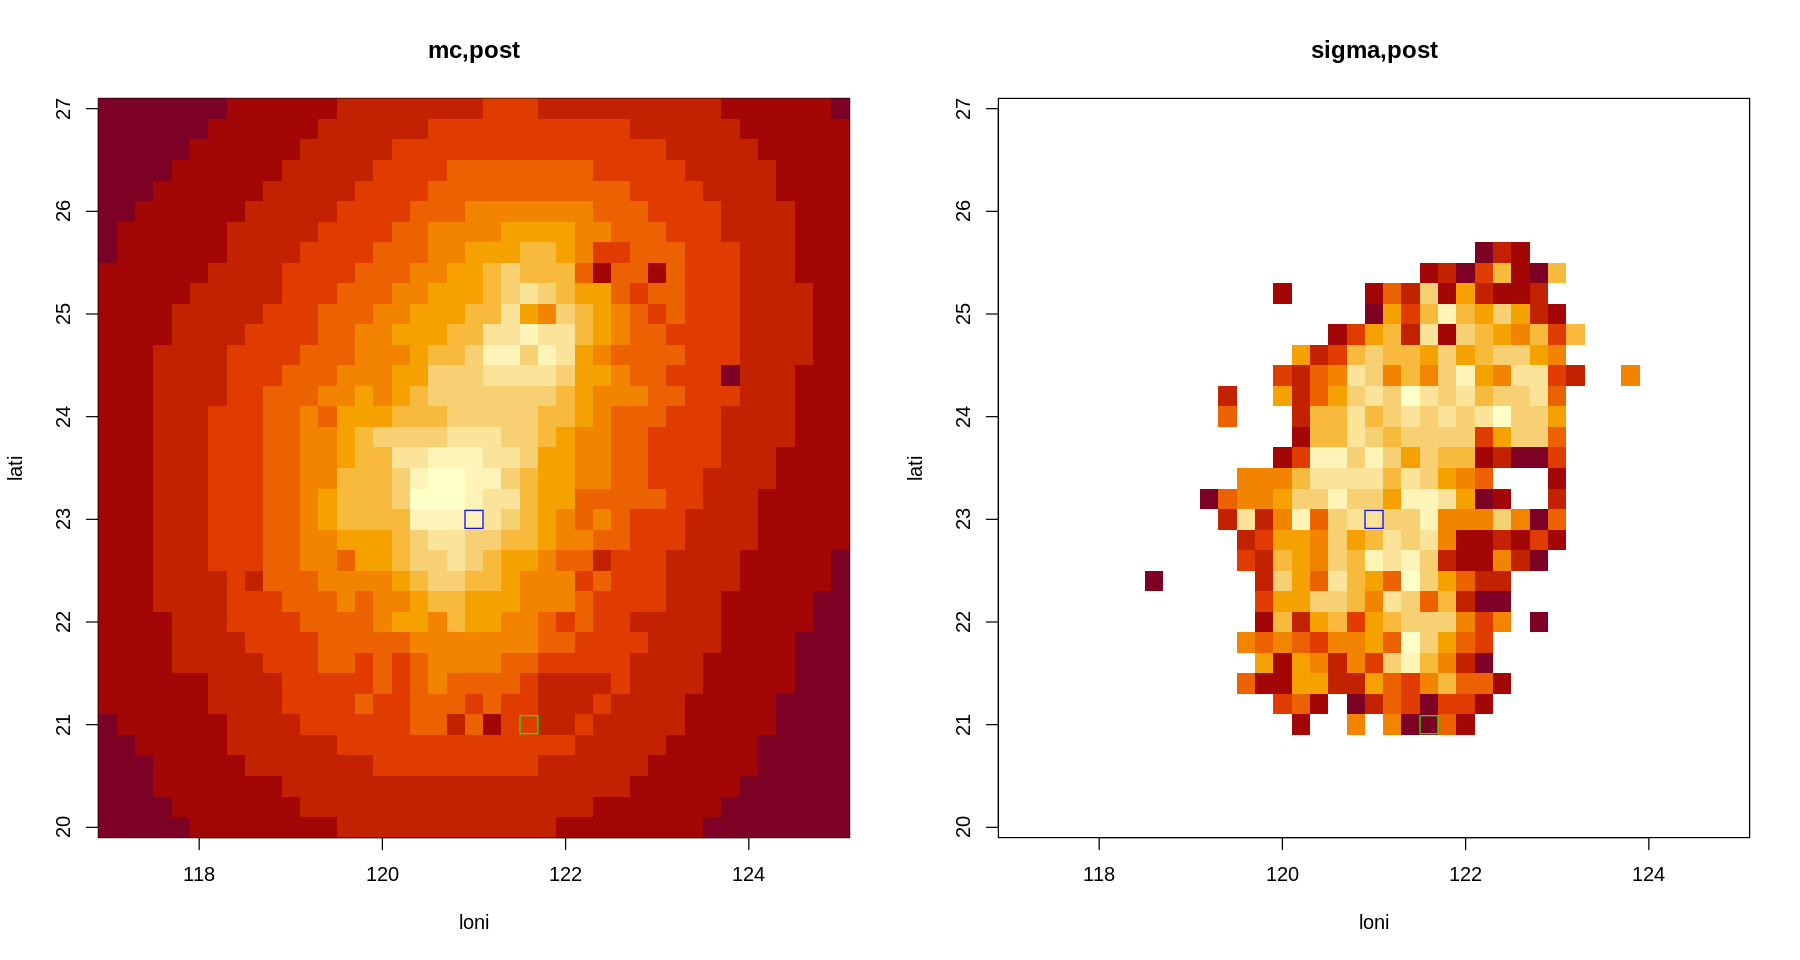

In [304]:
indna <- which(is.na(mc_post) == T)
mc_post[indna] <- mc_pred[indna]
sigma_post[indna] <- sigma_pred

indloc1 <- which(grid$lon >= 121 & grid$lat >= 23)[1]     # central area, low uncertainty on observation
indloc2 <- which(grid$lon >= 121.5 & grid$lat >= 21)[1]   # outer regaion, higher uncertainty on observation
check_loc1 <- grid[indloc1, ]
check_loc2 <- grid[indloc2, ]

par(mfrow = c(1,2))
image(loni, lati, matrix(mc_post, nrow = length(loni), ncol = length(lati)), main = 'mc,post')
points(check_loc1$lon, check_loc1$lat, pch = 0, cex = 10*dbin, col = 'blue')
points(check_loc2$lon, check_loc2$lat, pch = 0, cex = 10*dbin, col = 'green')

image(loni, lati, matrix(sigma_post, nrow = length(loni), ncol = length(lati)), main = 'sigma,post')
points(check_loc1$lon, check_loc1$lat, pch = 0, cex = 10*dbin, col = 'blue')
points(check_loc2$lon, check_loc2$lat, pch = 0, cex = 10*dbin, col = 'green')

**EXERCISE 2:** What are the differences between $m_{c,obs}$ and $m_{c,post}$ maps? Compare the two distributions for the 2 locations previously defined (use the above code 'Local likelihood distribution' as template).

The $m_{c,obs}$ and $m_{c,post}$ maps look similar, both have low uncertainty in the central area, but have larger uncertainty in the outer region. In particular, the sigma $m_{c,post}$ map is much larger, which means the predicted uncertainty is large where the grids have deeper color. 

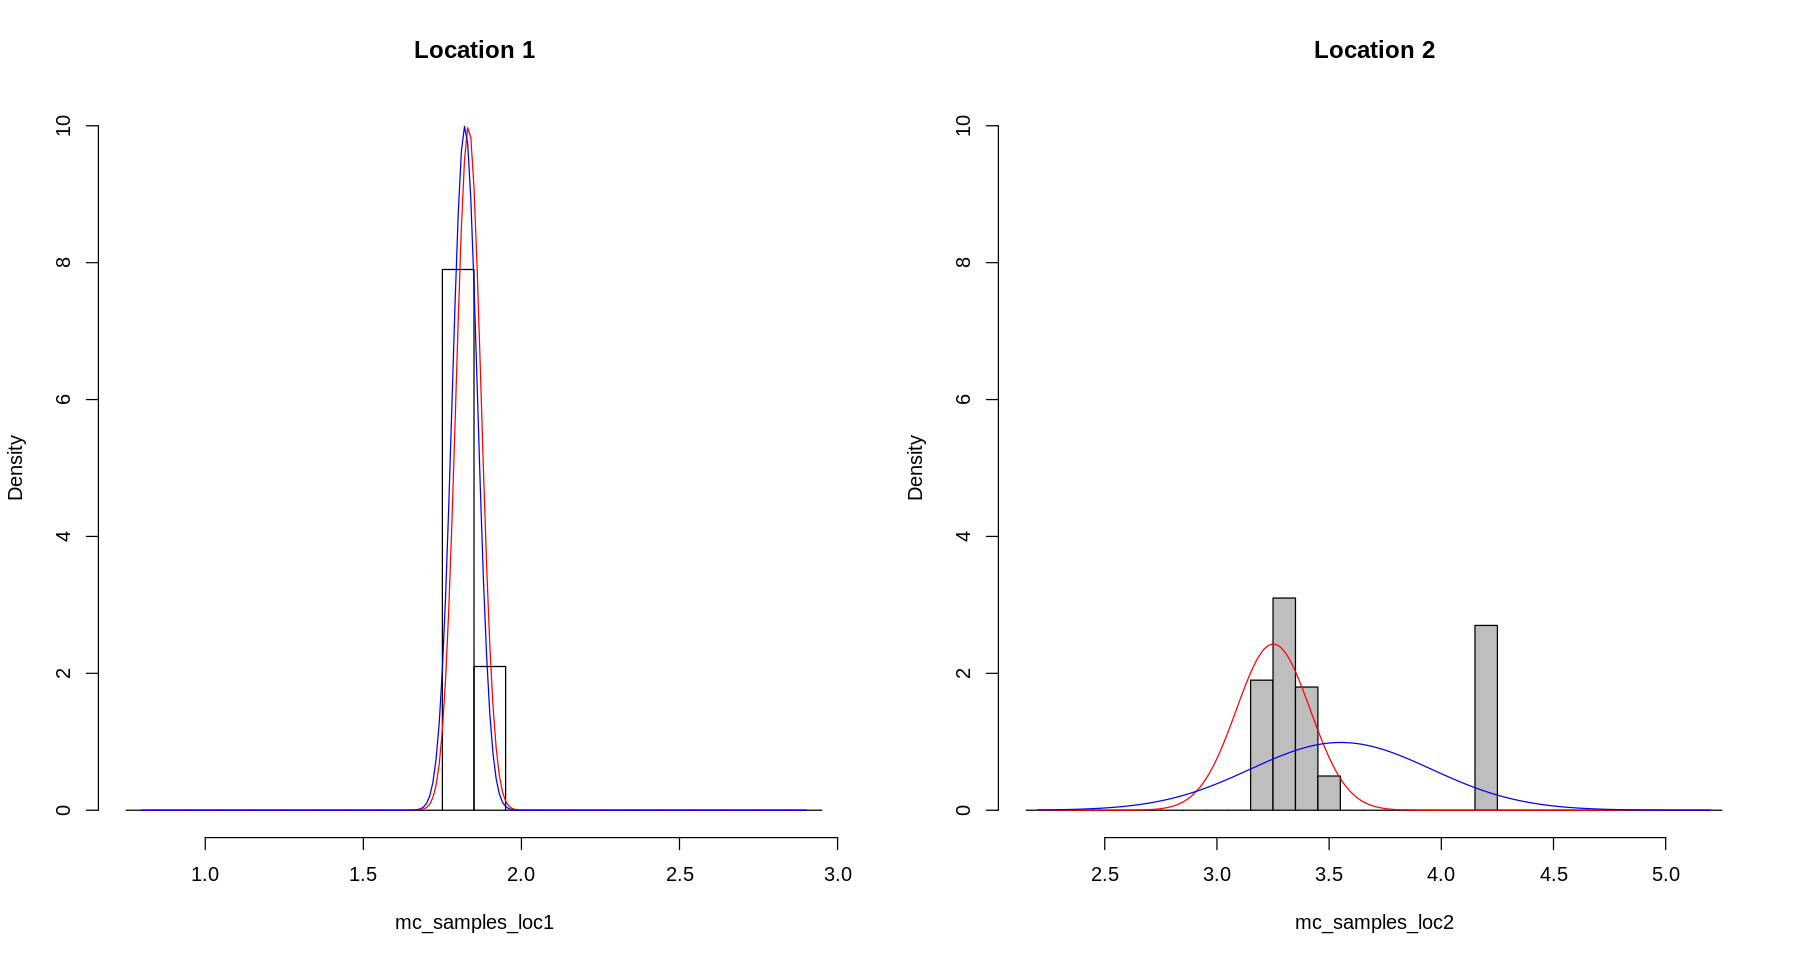

In [312]:
m_loc1 <- seism$m[unlist(ind.cell[indloc1])]
mc_samples_loc1 <- mc_samples[[indloc1]]
mc_post_loc1 <- mc_post[indloc1]
sigma_mc_post_loc1 <- sigma_post[indloc1]
mc_obs_loc1 <- mc_obs[indloc1]
sigma_mc_obs_loc1 <- sigma_obs[indloc1]

m_loc2 <- seism$m[unlist(ind.cell[indloc2])]
mc_samples_loc2 <- mc_samples[[indloc2]]
mc_post_loc2 <- mc_post[indloc2]
sigma_mc_post_loc2 <- sigma_post[indloc2]
mc_obs_loc2 <- mc_obs[indloc2]
sigma_mc_obs_loc2 <- sigma_obs[indloc2]

mdistr_loc1 <- fmd(m_loc1)
mdistr_loc2 <- fmd(m_loc2)

par(mfrow =c(1,2))

breaks <- seq(min(mc_samples_loc1, na.rm=T)-1.05, max(mc_samples_loc1, na.rm=T)+1.05, .1)
hist(mc_samples_loc1, breaks = breaks, freq = F, ylim = c(0, 10), main = 'Location 1')
mci <- seq(min(mc_samples_loc1, na.rm=T)-1, max(mc_samples_loc1, na.rm=T)+1, .01)
lines(mci, dnorm(mci, mean = mc_post_loc1, sd = sigma_mc_post_loc1), col = 'red')
lines(mci, dnorm(mci, mean = mc_obs_loc1, sd = sigma_mc_post_loc1), col = 'blue')

breaks2 <- seq(min(mc_samples_loc2, na.rm=T)-1.05, max(mc_samples_loc2, na.rm=T)+1.05, .1)
hist(mc_samples_loc2, breaks = breaks2, freq = F, ylim = c(0, 10), main = 'Location 2',col='grey')
mci2 <- seq(min(mc_samples_loc2, na.rm=T)-1, max(mc_samples_loc2, na.rm=T)+1, .01)
lines(mci2, dnorm(mci2, mean = mc_post_loc2, sd = sigma_mc_post_loc2), col = 'red')
lines(mci2, dnorm(mci2, mean = mc_obs_loc2, sd = sigma_mc_obs_loc2),  col = 'blue') # dnorm(x,mean,sd) return the P_norm_dis of x

## 3. References

* Efron (1979), Bootstrap Methods: Another Look at the Jackknife, The Annals of Statistics, 7 (1), 1-26
* Mignan et al. (2011), Bayesian Estimation of the Spatially Varying Completeness Magnitude of Earthquake Catalogs, Bull. Seismol. Soc. Am., 101 (3), 1371-1385
* Wu et al. (2008), A Comprehensive Relocation of Earthquakes in Taiwan from 1991 to 2005, Bull. Seismol. Soc. Am., 98 (3), 1471–1481

Notebook inspired from the GitHub tutorial: https://amignan.github.io/rseismNet/README.html